In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt

In [2]:
train_val_dataset = datasets.MNIST(root='../../datasets/mnist/', train=True, download=True)
test_dataset = datasets.MNIST(root='../../datasets/mnist/', train=False, download=True)

In [3]:
train_val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../../datasets/mnist/
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../../datasets/mnist/
     Split: Test)

In [4]:
class_names = train_val_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Text(0.5, 1.0, '5 - five')

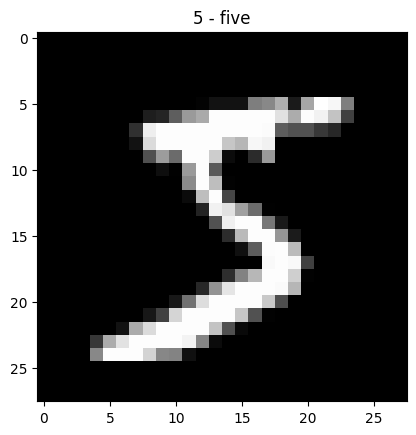

In [5]:
img, label = train_val_dataset[0]
plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}")

In [6]:
img = train_val_dataset.data[0]
img = img.numpy()
img.shape

(28, 28)

### Superimposing

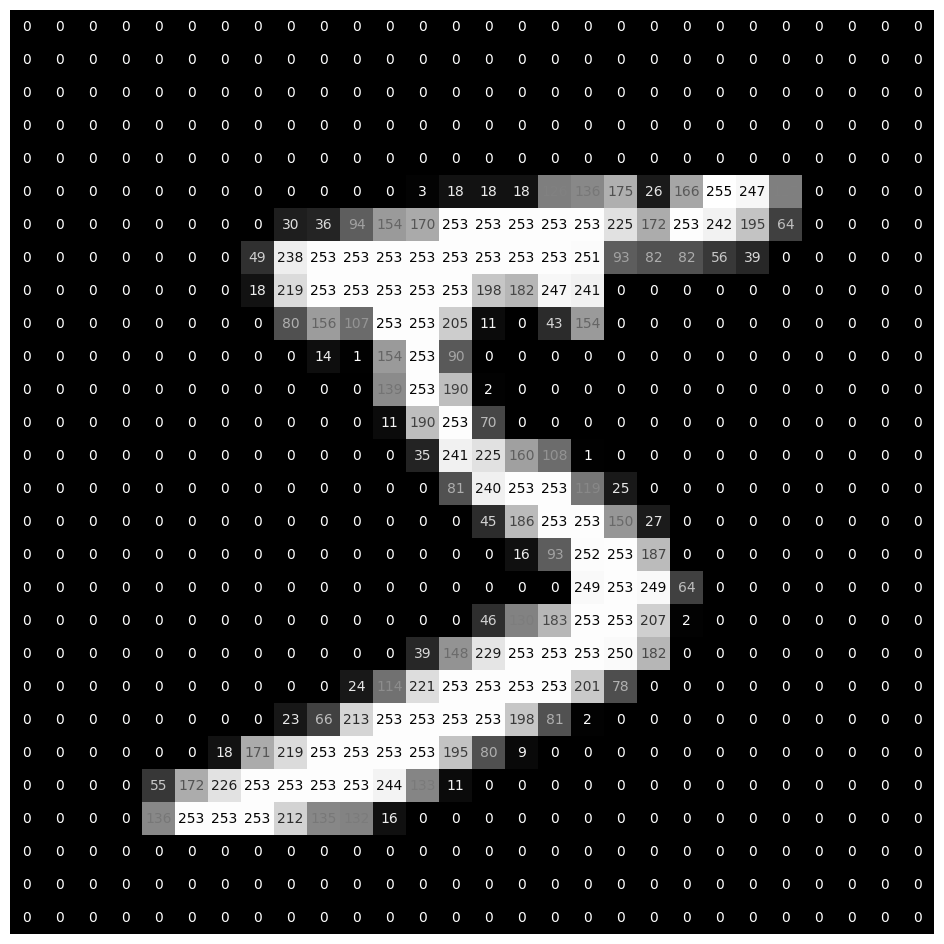

In [7]:
def img_pixel_superimpose(img, ax):
    w, h = img.shape
    color_map = plt.colormaps.get_cmap('gray_r')
    ax.imshow(img,cmap='gray')
    for x in range(w):
        for y in range(h):
            color = color_map(img[x][y])
            ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center', color=color)
            plt.axis(False)

fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(1,1,1)
img_0 = train_val_dataset.data[0]
img_0 = img_0.numpy()
img_pixel_superimpose(img_0, ax0)

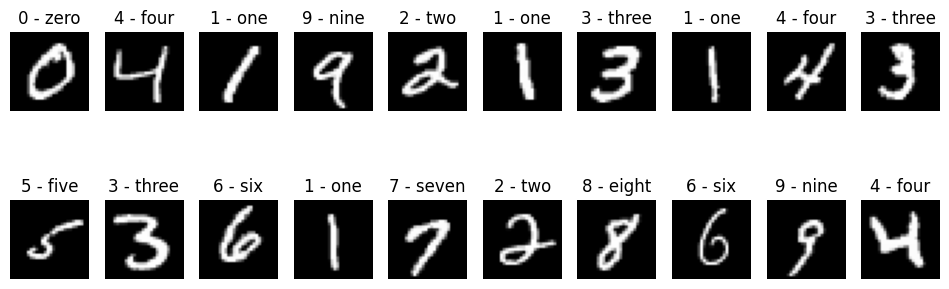

In [8]:
fig = plt.figure(figsize=(12,4))
fig.tight_layout()
rows, cols = 2, 10

for i in range(1, (rows * cols)+1):
    img, label = train_val_dataset[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)


### Preprocessing images

In [10]:
# converting to torch tensor
train_val_dataset = datasets.MNIST(root='../../datasets/mnist/', train=True, download=False, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='../../datasets/mnist/', train=False, download=False, transform=transforms.ToTensor())

In [11]:
# normalize and get mean and standard deviation
imgs = torch.stack([img for img, _ in train_val_dataset], dim=0)

mean = imgs.view(1,-1).mean(dim=1)
std = imgs.view(1,-1).std(dim=1)
print(mean, std)

tensor([0.1307]) tensor([0.3081])


Now gonna do the transformation like:  
    - Firstly convert to tensor  
    - Then Normalize the stack with mean and standard deviation


In [12]:
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std)]
)

In [13]:
# applying the above transformation
train_val_dataset = datasets.MNIST(root='../../datasets/mnist/', train=True, download=False, transform=mnist_transforms)
test_dataset = datasets.MNIST(root='../../datasets/mnist/', train=False, download=False, transform=mnist_transforms)
train_val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../../datasets/mnist/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../../datasets/mnist/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
            ))

In [14]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[50000,10000])
len(train_dataset), len(val_dataset), len(test_dataset)

(50000, 10000, 10000)

### Dataloaders

In [15]:
BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

3125 625 625


### LeNet-5 architecture and modelling

In [16]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2), # 28X28 --> 32X32 --> 28x28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2), # 14X14

            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), #10X10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2), #5X5
        )
        self.classifer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
    
    def forward(self, x):
        return self.classifer(self.feature(x))
    
model_lenet5v1 = LeNet5V1()

In [17]:
# model summary
summary(model=model_lenet5v1, input_size=(1,1,28,28), col_width=20, col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=1)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5V1 (LeNet5V1)                      [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 1, 28, 28]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classife

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5V1 (LeNet5V1)                      [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 1, 28, 28]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classife